In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [41]:
bin_size = 1_000

Function to load coverage data

In [51]:
def load_coverage(filename, replicate_label):
    df = pd.read_csv(filename, sep='\t', header=None, names=['contig', 'position', 'coverage'])
    df['replicate'] = replicate_label
    return df

Aggregation function

In [52]:
def aggregate_coverage(df, bin_size=1000):
    df['bin'] = ((df['position'] - 1) // bin_size) * bin_size
    agg_df = df.groupby(['contig', 'bin'])['coverage'].mean().reset_index()
    return agg_df

Merge replicates

In [53]:
def merge_and_aggregate(files, labels, bin_size=1000):
    dfs = []

    for file, label in zip(files, labels):
        df = load_coverage(file, label)
        df_agg = aggregate_coverage(df, bin_size=bin_size)
        df_agg = df_agg.rename(columns={'coverage': label})
        dfs.append(df_agg)

    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on=['contig', 'bin'], how='outer')

    merged_df = merged_df.fillna(0)
    return merged_df

Custom PairGrid with Pearson r annotation

In [88]:
def plot_scatter_matrix(df, replicates):

    log_df = np.log10(df[replicates] + 1)
    sns.set(style='ticks')

    def corrfunc(x, y, **kwargs):
        r, _ = pearsonr(x, y)
        ax = plt.gca()
        ax.annotate(f"r = {r:.2f}", xy=(0.6, 0.1), xycoords=ax.transAxes, fontsize=10, color='darkred')

    # Create full pairplot (with diag so we can hide it)
    g = sns.pairplot(
        log_df,
        plot_kws={'s': 10, 'alpha': 0.5},
        diag_kind='kde',
        corner=False  # full matrix, so we can hide both upper and diagonal
    )

    # Hide upper triangle and diagonal plots
    for i in range(len(replicates)):
        for j in range(len(replicates)):
            ax = g.axes[i][j]
            if j > i:  # upper triangle
                ax.set_visible(False)
            elif i == j:  # diagonal
                ax.set_visible(False)

    # Add Pearson r to lower triangle
    g.map_lower(corrfunc)

    # Only keep x-ticks on bottom and y-ticks on left
    for i in range(len(replicates)):
        for j in range(len(replicates)):
            ax = g.axes[i][j]
            if ax is not None and ax.get_visible():
                ax.tick_params(
                    labelbottom=(i == len(replicates) - 1),
                    labelleft=(j == 0))

    g.fig.suptitle("Log10 aggregated coverage depth (1kb bins)", y=1.02)
    plt.tight_layout()
    plt.show()


In [97]:
def plot_kde_replicate_distributions(df, replicates, output_file='kde_coverage_distributions.png'):

    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))

    for rep in replicates:
        coverage = df[rep]
        log_cov = np.log10(coverage + 1)
        sns.kdeplot(log_cov, label=rep, bw_adjust=0.5)

    plt.xlabel("Log10 mean coverage depth")
    plt.ylabel("Density")
    plt.title("Coverage depth distribution across replicates (1kb bins)")
    plt.legend(title='Replicate')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.show()
    print(f"Saved KDE plot to {output_file}")


Plot aggregated coverage scatter

In [105]:
def plot_coverage_along_genome_stacked(df, replicates, output_file='coverage_along_genome.png'):
    sns.set(style='whitegrid')
    num_reps = len(replicates)
    fig, axes = plt.subplots(num_reps, 1, figsize=(14, 3.5 * num_reps), sharex=False)

    # Ensure axes is iterable for 1 replicate
    if num_reps == 1:
        axes = [axes]

    for ax, rep in zip(axes, replicates):
        for contig in df['contig'].unique():
            subset = df[df['contig'] == contig]
            ax.scatter(
                subset['bin'], np.log10(subset[rep] + 1),
                s=2, alpha=0.5, label=contig
            )
        ax.set_title(f'Aggregated coverage depth along genome for {rep} (1kb bins)', fontsize=11)
        ax.set_ylabel('Log10 mean coverage depth')
        ax.legend(title='Contig', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        ax.set_xlabel('Genomic position (bin start)')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.close()
    print(f"Saved plot to {output_file}")

Load and aggregate data

In [55]:
files = ['/Users/linus/Desktop/python_sandbox/coverage_files/ERR1797969_coverage.txt',
         '/Users/linus/Desktop/python_sandbox/coverage_files/ERR1797970_coverage.txt',
         '/Users/linus/Desktop/python_sandbox/coverage_files/ERR1797971_coverage.txt',
         '/Users/linus/Desktop/python_sandbox/coverage_files/ERR1797972_coverage.txt',
         '/Users/linus/Desktop/python_sandbox/coverage_files/ERR1797973_coverage.txt',
         '/Users/linus/Desktop/python_sandbox/coverage_files/ERR1797974_coverage.txt']
    
labels = ['ERR1797969', 'ERR1797970', 'ERR1797971', 'ERR1797972', 'ERR1797973', 'ERR1797974']

# Aggregate to 1 kb windows
coverage_df = merge_and_aggregate(files, labels, bin_size=bin_size)
print(coverage_df.head())

        contig   bin  ERR1797969  ERR1797970  ERR1797971  ERR1797972  \
0  tig00000001     0    5.664773    3.085627    6.073482    3.847021   
1  tig00000001  1000    7.196182    6.534000    8.628125    4.934919   
2  tig00000001  2000    3.490975    3.268539    3.051583    1.857571   
3  tig00000001  3000    2.774559    3.007246    3.774900    2.554430   
4  tig00000001  4000    1.680672    1.071429    1.972678    1.326733   

   ERR1797973  ERR1797974  
0    5.366577    1.669231  
1    4.422965    2.701973  
2    2.225710    1.942529  
3    1.535533    1.692308  
4    1.960000    1.883333  


Plot all replicates in one plot

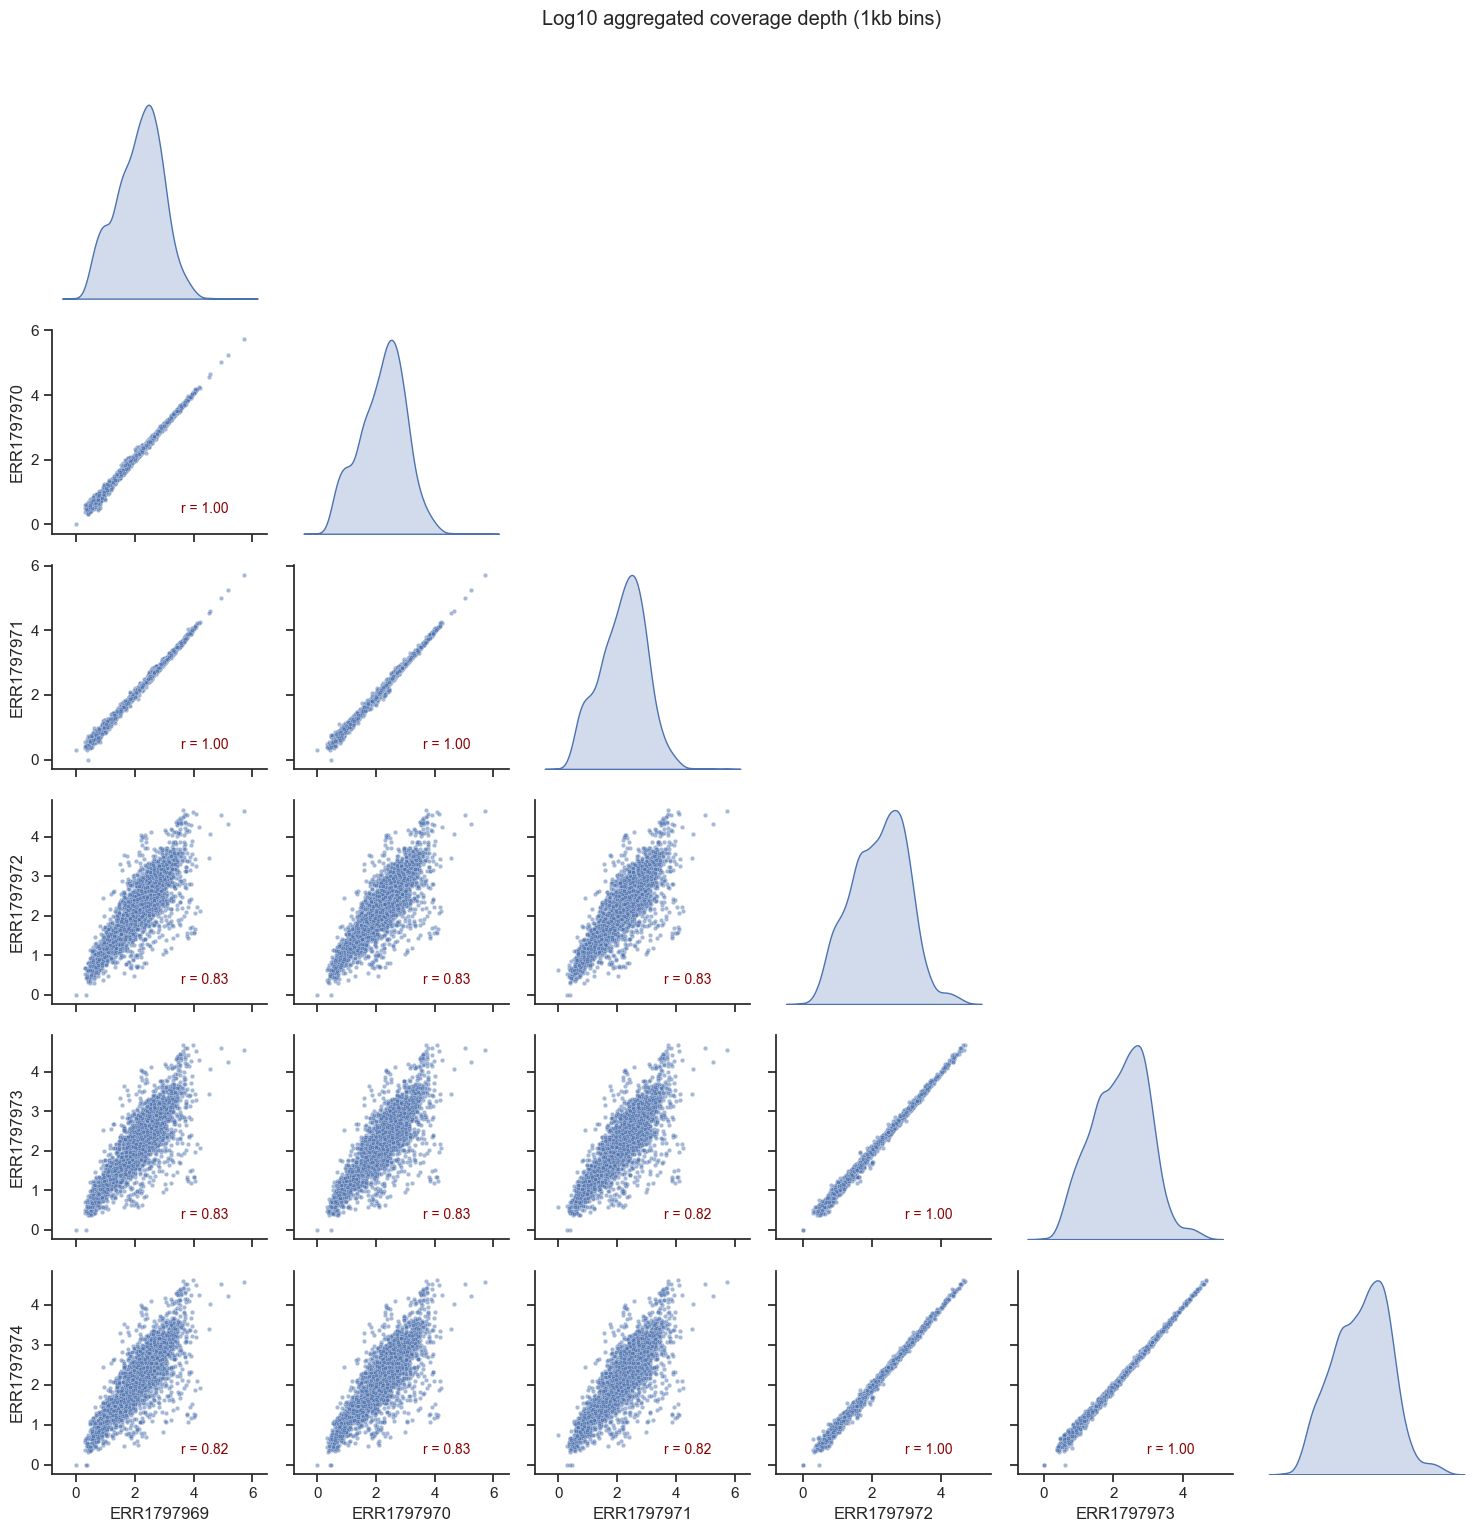

In [91]:
plot_scatter_matrix(coverage_df, labels)

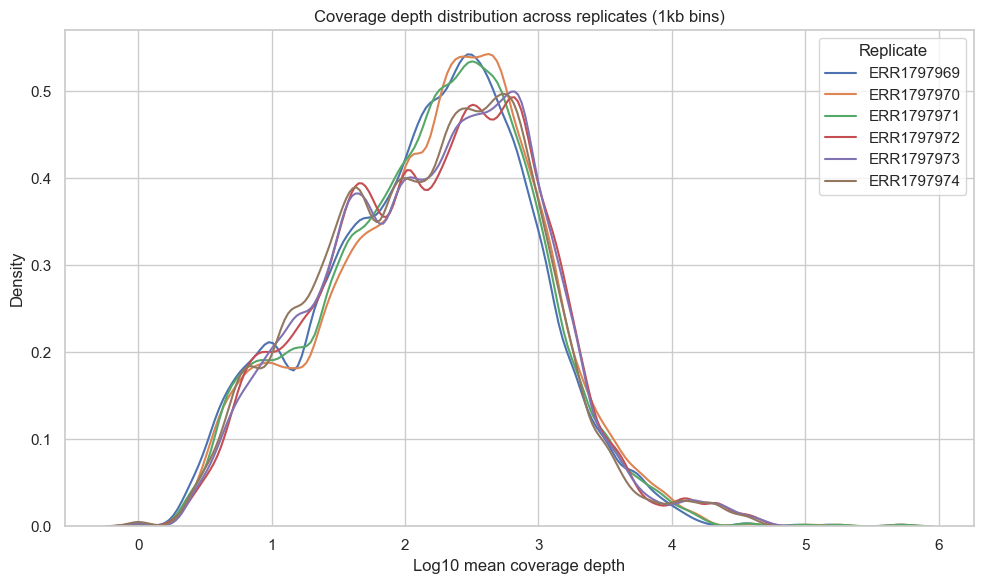

Saved KDE plot to kde_coverage_distributions.png


In [98]:
plot_kde_replicate_distributions(coverage_df, labels)

Coverage depth vs. Position scatterplot for each replicate

In [106]:
plot_coverage_along_genome_stacked(coverage_df, labels)

Saved plot to coverage_along_genome.png
